# 逻辑回归
  
回归，是指假设一个模型，设定一些参数，计算合适的参数以拟合逼近现有数据。

#### Linear Regression
$$h_\theta(x) = θ^Tx+θ_0$$
#### Logistic Regression
$$h_\theta(x) = g(θ^Tx+θ_0) = P(y=1|x,θ)$$
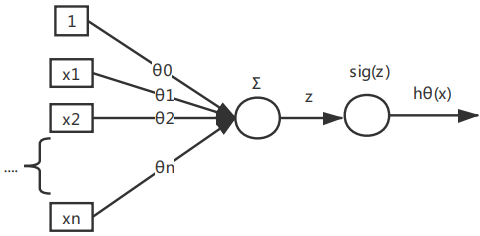


线性回归用一条直线模型去拟合数据，用来确定两种或两种以上变量间相互依赖的定量关系

逻辑回归计算样本属于某个标签的概率，构建一个分类边界，用来对数据进行二分类或者多分类。

上次实验我们用梯度下降训练了一个线性回归模型，这次我们实现一个逻辑回归模型来进行二分类的收入判断任务。

##### 注意事项：
本实验可能用到的函数：`np.mean` `np.add` `np.sum` `np.mutual` `np.dot`

本实验大部分变量为numpy array的数据类型

### 任务一：读取和预处理数据

第一步导入数据。压缩包中的train.csv中存储了原始数据，每人拥有年龄，工作类型等14个维度，共32561个样本。最后一个维度为本次实验的label，即收入是否大于50k。

做机器学习应用的时候很多时间是花费在特征处理上，我们注意到原始数据存在许多维度为非数字的数据，是不能直接用于构建模型的。我们可以通过离散化，把一个维度扩展到多个维度。如教育程度：（小学，初中，高中+）可以被扩展到如下三个维度：小学学历（是，否），初中学历（是，否），高中学历以上（是，否）。

经上述处理后的数据存储在X_train文件中，每个样本的维度被扩展到了106维，本实验直接使用其中的数据构建模型。

In [1]:
import numpy as np 
from matplotlib import pyplot as plt

def getdata(X_train,Y_train):
    X = np.genfromtxt(X_train,delimiter=',',skip_header=1) #32561个样本*106个特征
    Y = np.genfromtxt(Y_train,delimiter=',',skip_header=1) #32561个label
    return X,Y

def shuffle(X,Y):
    #打乱X,Y,避免数据存在初始的排序，影响训练效果
    randomize = np.arange(len(X)) #不同的库用的不太一样，返回的对象也不太一样。python自带的range()不支持numpy的shuffle
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize]) #ndarray的参数是数组时，返回一个依参数排序后的数组    

def train_test_split(X, Y, test_size=0.1155):
    #按一个比例分出一部分验证集
    train_len = int(round(len(X)*(1-test_size)))
    return X[0:train_len], Y[0:train_len], X[train_len:None], Y[train_len:None]

X,Y = getdata('X_train','Y_train')
X, Y, X_test, Y_test = train_test_split(X, Y)

X.shape #out: (28800, 106)

(28800, 106)

### 任务二：数据归一化

归一化把每个特征的数据映射到0到1之间，消除指标之间的量纲影响，同时可以避免某些特征对模型预测结果的影响过大。

常用的归一化方法有两种：
一是利用最大最小值(min-max 归一化)；

二是利用平均值方差(z-score 0均值标准化)。

一般来说0均值标准化调整了数据的分布，使之更易于训练。

In [12]:
def normalization(X):
    """将X中的数据映射到0-1之间
    参数：
        X:数据
    返回：
        归一化之后的X
    注意：
        测试在只归一化0,1,3,4,5,7,10,12,25,26,27,28列特征时，效果会比较好
        具体原因可探讨
    """    
    ### START THE CODE ###

    mu=np.mean(X,axis=0)
    sigma=np.std(X,axis=0)
    X=(X-mu)/sigma
    
    ### END THE CODE ###
    
    return X
    
X = normalization(X)
X_test = normalization(X_test)
X_test=np.nan_to_num(X_test)
X[:1]

<ipython-input-12-c5a6bb11b4ee>:15: RuntimeWarning: invalid value encountered in true_divide
  X=(X-mu)/sigma


array([[ 0.02890209, -1.06650057,  0.70335357,  0.14210542, -0.21597229,
        -0.03377446, -0.17470564, -0.26245687, -0.0131773 , -1.51399507,
        -0.18897204, -0.2927921 ,  4.90786186, -0.01954713, -0.24317697,
        -0.17215644, -0.19461562, -0.11501416, -0.06989175, -0.10207818,
        -0.1432363 , -0.12655579, -0.1828753 , -0.20941936,  2.24646595,
        -0.11423684, -0.69141886, -0.23563746, -0.03999722, -0.13305565,
        -0.53564986, -0.39781224, -0.02701294, -0.92012355, -0.1148591 ,
         1.43151402, -0.1819608 , -0.17929607,  2.73780482, -0.01666898,
        -0.37970232, -0.37616249, -0.17774285, -0.20724196, -0.25605007,
        -0.33724199, -0.06862635, -0.38101806, -0.14158655, -0.35572488,
        -0.17076159, -0.22655045, -0.24357715, -0.82330602,  1.70272396,
        -0.17491659, -0.42976465, -0.34397138, -0.22493651, -0.0987262 ,
        -0.18073519, -0.32647469, -0.09243708,  0.41359997, -0.02430281,
        -0.06248257, -0.04828886, -0.04253024, -0.0

### 任务三：完成sigmoid函数

sigmoid funtion函数原指曲线是 “S”形的函数，logistic function则指满足某个公式形式的一系列函数。
在机器学习中，其一般特指以下函数（standard logistic function）：
$$f(x) = \frac{1}{1+e^{-z}}$$

In [13]:
def sigmoid(z):
    """
    参数：
        z
    返回：
        sigmoid(z)
    """   
    ### START THE CODE ###
    
    s = (1 / (1 + np.exp(-z)))

    ### END THE CODE ###
    
    return np.clip(s, 1e-6, 1-1e-6)
    #clip:重要的处理，将超出范围的值强制置为边界值，避免y_pred为0，从而导致下面交叉熵损失无法计算
    #aeN: a*10的N次方
    
sigmoid(0.3) #out:0.574442516811659

0.574442516811659

### 任务四：完成交叉熵损失函数
$$J(\theta)=-\frac{1}{m}\sum_1^m[y^ilog(h_\theta(x^i))+(1-y^i)log(1-h_\theta(x^i))]$$
损失函数用于评价模型预测同实际情况的差异，越小说明预测越准确。

概念上, 损失函数针对单个样本，代价函数针对总体。但作为优化目标时二者无不同。

交叉熵数学意义上衡量的是两个概率分布间的差异，本实验以交叉熵损失为优化目标函数。

In [14]:
def cost(y_pred, y_label, m):
    """代价函数，这里计算的是所有样本损失函数的和
    参数：
        y_pred：模型预测的值
        y_label：数据实际的标签
        m：数据的样本数
    返回：
        cst: 预测值同标签值之间的代价
    """   
    ### START THE CODE ###
    
    y_pred = np.array(y_pred)
    y_label = np.array(y_label)
    cst =  -np.sum(np.dot(y_label , np.log(y_pred)) + np.dot((1 - y_label) , np.log((1 - y_pred)))) / m
    
    ### END THE CODE ###
    
    return cst

cost(0.5,0.5,1) #out:0.6931471805599453   numpy的log以e为底

0.6931471805599453

### 任务五：构建逻辑回归模型

$$\hat y=sig(θ_1*x_1+θ_2*x_2+...+θ_n*x_n+θ_0)$$

接下来先设置模型所需要的参数，可以自己修改观察对模型的影响。

对于样本的偏置θ0，有两种处理方法：
一种是作为一个维度添加到array θ上，相应样本也要添加一个值全为1的维度；

一种是单独拿出来更新，在梯度下降时分别处理。

本实验采取的是第二种方法。

最后完成模型所需的两个基本函数predict，和accuracy。

In [16]:
#模型的基本参数：
theta = np.zeros(X.shape[1],) #106个权重参数，初值全为0
theta_0 = np.zeros(1,) #1个偏置参数，初值为0

#训练参数
max_iter = 40 #迭代次数
batch_size = 32 #随机梯度下降中每次取样个数
learning_rate = 0.002 #学习率，可以尝试不同的学习率，如0.2、0.002、0.0002
num_train = len(Y)
num_test = len(Y_test)

#用于记录训练中损失和准确率的变化
train_cost = []
test_cost = []
train_acc = []
test_acc = []

def predict(X, theta, theta_0):
    """预测
    参数：
        X：样本特征
        theta：权重参数 
        theta_0: 偏置参数
    返回：
        Y_pred: 样本的预测值 0~1
    """      
    ### START THE CODE ###
    
    X = np.array(X)
    theta = np.array(theta)
    Y_pred = np.dot(X , theta) + theta_0
    Y_pred = sigmoid(Y_pred)
    
    ### END THE CODE ###
    
    return Y_pred

def accuracy(Y_hat, Y_label):
    """准确率
    参数：
        Y_hat：样本最终分类 0 or 1
        Y_label：样本标签
    返回：
        acc: 分类准确率
    """      
    ### START THE CODE ###
    
    acc = np.sum(np.abs(Y_hat - Y_label)) / len(Y_hat)
    acc = 1 -acc
    
    ### END THE CODE ###
    
    return acc

predict([0.5,1],[0,0.2],[0.1]) #out: array([0.57444252])

array([0.57444252])

### 任务六：用随机梯度下降算法训练模型

全样本的梯度下降，在样本过大时，更新一次参数会需要巨大计算量。我们可以每次从中随机取出一定大小的样本，进行小批量随机梯度下降。
随机取样部分已完成，只需根据样本梯度下降更新参数即可。

根据我们的优化目标（默认为交叉熵），对损失函数求导，得到梯度计算公式为：
$$(h_\theta(x^i)-y)x^i$$(推导见ppt)

θ，θ0更新时分别处理

In [21]:
def gradient_descent(x_bt, y_bt, theta, theta_0, learning_rate):
    """用每次取出的一个batch的数据训练模型
    参数：
        x_bt:本次更新所用样本
        y_bt:本次更新样本的标签
        theta,theta_0：模型参数
    过程：
        用theta,theta_0进行一次预测
        计算预测误差
        计算theta, theta_0的梯度，取均值
        用梯度更新theta_0和theta
    """ 
    ### START THE CODE ###

    h_theta = predict(x_bt , theta , theta_0)
    grad = np.dot((h_theta - y_bt) , x_bt)

    theta -= (learning_rate * grad)
    theta_0 -= learning_rate * np.sum(grad)/x_bt.shape[1]
    
    ### END THE CODE ###
    
    return theta,theta_0

gradient_descent(np.array([[1]]),np.array([1]),np.array([0.1]),np.array([0.1]),0.2)
#out: (array([0.1900332]), array([0.1900332]))

(array([0.1900332]), array([0.1900332]))

In [22]:
def train(X, Y, theta, theta_0, max_iter, batch_size, learning_rate):
    train_cost = []
    test_cost = []
    train_acc = []
    test_acc = []

    for epoch in range(max_iter):
        X, Y = shuffle(X, Y) #随机打乱各行数据，这样参数不易陷入局部最优，模型能够更容易达到收敛。 
        for i in range(int(np.floor(len(Y)/batch_size))): #每个batch更新一次
            x_bt = X[i*batch_size:(i+1)*batch_size] #32个样本*106维
            y_bt = Y[i*batch_size:(i+1)*batch_size] #32个label
            
            #每个batch的样本更新参数theta,theta_0
            theta,theta_0 = gradient_descent(x_bt,y_bt,theta,theta_0,learning_rate)
        
        #记录每个epoch更新后，训练集上损失的变化和准确率的变化
        Y_pred = predict(X, theta, theta_0)
        Y_hat = np.round(Y_pred)
        train_acc.append(accuracy(Y_hat, Y))
        train_cost.append(cost(Y_pred, Y, num_train))
        #记录每个epoch更新后，测试集上损失的变化和准确率的变化
     
        Y_test_pred = predict(X_test, theta, theta_0)
        Y_test_hat = np.round(Y_test_pred)    
        test_acc.append(accuracy(Y_test_hat, Y_test))
        test_cost.append(cost(Y_test_pred, Y_test, num_test))
        
    return train_cost,test_cost,train_acc,test_acc
        
train_cost,test_cost,train_acc,test_acc = train(X, Y, theta, theta_0, max_iter, batch_size, learning_rate)      
len(train_cost) #out: 40

40

### 任务七：观察模型在训练集和验证集上的表现

用matplotlib(plt)里的方法生成图表，观察随着迭代进行，模型损失和准确率的变化

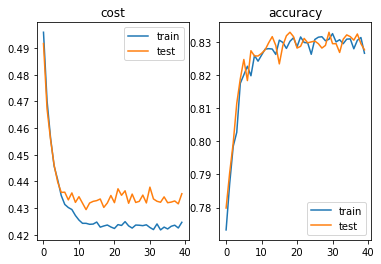

In [23]:
#子图1：损失
p1 = plt.subplot(121)
p1.plot(train_cost)
p1.plot(test_cost)
p1.legend(['train', 'test'])
p1.set_title("cost")

#子图2，准确率
p2 = plt.subplot(122)
p2.plot(train_acc)
p2.plot(test_acc)
p2.legend(['train', 'test'])
p2.set_title("accuracy")
plt.show()

### 样例输出：
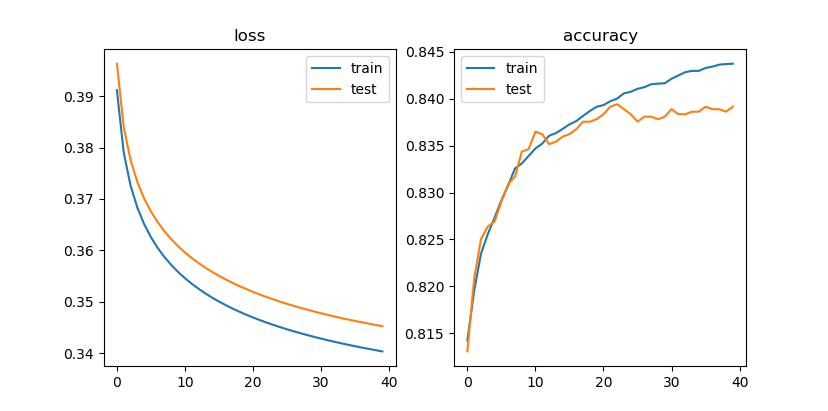
由于训练过程有一定随机性，训练结果可能存在不同